In [38]:
import sys
import platform
import warnings
import src.features.labeller as lab
import src.features.bars as bar

from multiprocessing import cpu_count

from pathlib import PurePath

from src.utils.utils import get_relative_project_dir, cprint

warnings.filterwarnings("ignore")

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'

#file_name = 'IVE_dollarValue_resampled_1s'
file_name = 'IVE_tickbidask_clean'
file_ext = '.parq'

parq_file_name = file_name + file_ext
# Load from parquet
infp = PurePath(data_interim_dir / parq_file_name)

df = pd.read_parquet(infp)
#resample to 1 min - remove duplicates
df = df.resample('1T').sum().drop_duplicates().dropna()


bars = bar.Bars()

dbars = bars.dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
close = dbars.price.copy()

cprint(close)


Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


  0%|          | 0/565466 [00:00<?, ?it/s]

 19%|█▉        | 106745/565466 [00:00<00:00, 1067438.29it/s]

 45%|████▍     | 251888/565466 [00:00<00:00, 1159460.49it/s]

 73%|███████▎  | 414462/565466 [00:00<00:00, 1268615.85it/s]

100%|██████████| 565466/565466 [00:00<00:00, 1467226.43it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
dates                        
2019-02-22 15:33:00  677.6299
2019-02-22 15:39:00  225.6800
2019-02-22 15:52:00  451.5470
2019-02-22 15:55:00  564.6950
2019-02-22 15:56:00  904.2716
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49060 entries, 2009-09-28 09:46:00 to 2019-02-22 15:56:00
Data columns (total 1 columns):
price    49060 non-null float64
dtypes: float64(1)
memory usage: 766.6 KB
None
-------------------------------------------------------------------------------



In [39]:
import src.strategy.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7

close_df = crossover.close_df(close, fast_window, slow_window)

cprint(close_df)




-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price        fast        slow
dates                                                
2019-02-22 15:33:00  677.6299  436.225111  427.607010
2019-02-22 15:39:00  225.6800  383.588833  402.366134
2019-02-22 15:52:00  451.5470  400.578375  408.513742
2019-02-22 15:55:00  564.6950  441.607531  428.036399
2019-02-22 15:56:00  904.2716  557.273548  487.565799
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49060 entries, 2009-09-28 09:46:00 to 2019-02-22 15:56:00
Data columns (total 3 columns):
price    49060 non-null float64
fast     49060 non-null float64
slow     49060 non-null float64
dtypes: float64(3)
memory usage: 1.5 MB
None
-------------------------------------------------------------------------------



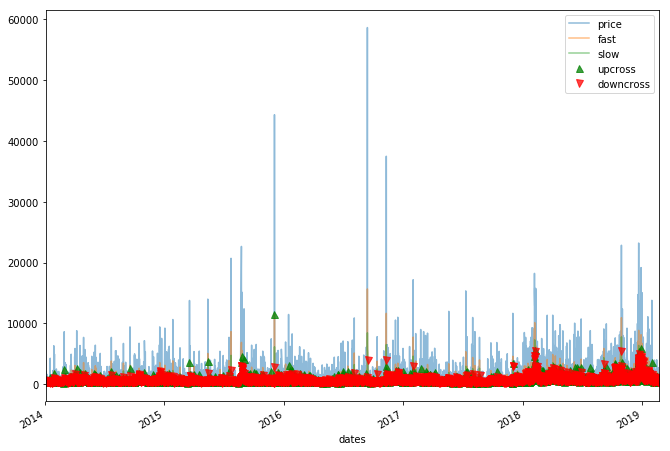

In [40]:
import matplotlib.pyplot as plt

up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [41]:
side = crossover.get_side(close, fast_window, slow_window)
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2019-02-22 12:31:00  1
2019-02-22 13:49:00 -1
2019-02-22 15:33:00  1
2019-02-22 15:39:00 -1
2019-02-22 15:55:00  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9910 entries, 2009-09-28 10:13:00 to 2019-02-22 15:55:00
Data columns (total 1 columns):
0    9910 non-null int64
dtypes: int64(1)
memory usage: 154.8 KB
None
-------------------------------------------------------------------------------



In [42]:
minRet = .01 
ptsl=[1, 2]

labeller = lab.Labeller()

dailyVol = labeller.getDailyVol(close_df['price'])
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target=dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)
cprint(ma_events)

  0%|          | 0/49058 [00:00<?, ?it/s]

  1%|          | 509/49058 [00:00<00:09, 5088.63it/s]

  2%|▏         | 1015/49058 [00:00<00:09, 5078.22it/s]

  3%|▎         | 1714/49058 [00:00<00:08, 5530.95it/s]

  5%|▌         | 2466/49058 [00:00<00:07, 6007.15it/s]

  7%|▋         | 3221/49058 [00:00<00:07, 6397.29it/s]

  8%|▊         | 3962/49058 [00:00<00:06, 6670.17it/s]

 10%|▉         | 4689/49058 [00:00<00:06, 6837.30it/s]

 11%|█         | 5451/49058 [00:00<00:06, 7053.20it/s]

 13%|█▎        | 6206/49058 [00:00<00:05, 7194.31it/s]

 14%|█▍        | 6956/49058 [00:01<00:05, 7282.52it/s]

 16%|█▌        | 7705/49058 [00:01<00:05, 7343.29it/s]

 17%|█▋        | 8478/49058 [00:01<00:05, 7453.49it/s]

 19%|█▉        | 9224/49058 [00:01<00:05, 7454.98it/s]

 20%|██        | 9996/49058 [00:01<00:05, 7530.13it/s]

 22%|██▏       | 10771/49058 [00:01<00:05, 7592.90it/s]

 24%|██▎       | 11537/49058 [00:01<00:04, 7611.63it/s]

 25%|██▌       | 12301/49058 [00:01<00:04, 7618.80it/s]

 27%|██▋       | 13064/49058 [00:01<00:04, 7619.96it/s]

 28%|██▊       | 13826/49058 [00:01<00:04, 7619.95it/s]

 30%|██▉       | 14588/49058 [00:02<00:04, 7586.05it/s]

 31%|███▏      | 15347/49058 [00:02<00:04, 7579.06it/s]

 33%|███▎      | 16105/49058 [00:02<00:04, 7569.67it/s]

 34%|███▍      | 16875/49058 [00:02<00:04, 7607.83it/s]

 36%|███▌      | 17648/49058 [00:02<00:04, 7642.19it/s]

 38%|███▊      | 18413/49058 [00:02<00:04, 7640.70it/s]

 39%|███▉      | 19178/49058 [00:02<00:03, 7599.14it/s]

 41%|████      | 19938/49058 [00:02<00:03, 7574.38it/s]

 42%|████▏     | 20699/49058 [00:02<00:03, 7582.44it/s]

 44%|████▎     | 21458/49058 [00:02<00:03, 7578.57it/s]

 45%|████▌     | 22216/49058 [00:03<00:03, 7559.59it/s]

 47%|████▋     | 22979/49058 [00:03<00:03, 7579.85it/s]

 48%|████▊     | 23740/49058 [00:03<00:03, 7588.30it/s]

 50%|████▉     | 24508/49058 [00:03<00:03, 7613.11it/s]

 52%|█████▏    | 25270/49058 [00:03<00:03, 7594.21it/s]

 53%|█████▎    | 26034/49058 [00:03<00:03, 7605.98it/s]

 55%|█████▍    | 26802/49058 [00:03<00:02, 7626.99it/s]

 56%|█████▌    | 27565/49058 [00:03<00:02, 7616.65it/s]

 58%|█████▊    | 28327/49058 [00:03<00:02, 7608.76it/s]

 59%|█████▉    | 29090/49058 [00:03<00:02, 7612.43it/s]

 61%|██████    | 29858/49058 [00:04<00:02, 7630.35it/s]

 62%|██████▏   | 30622/49058 [00:04<00:02, 7623.19it/s]

 64%|██████▍   | 31385/49058 [00:04<00:02, 7602.83it/s]

 66%|██████▌   | 32146/49058 [00:04<00:02, 7596.57it/s]

 67%|██████▋   | 32908/49058 [00:04<00:02, 7602.49it/s]

 69%|██████▊   | 33673/49058 [00:04<00:02, 7614.20it/s]

 70%|███████   | 34435/49058 [00:04<00:01, 7612.72it/s]

 72%|███████▏  | 35197/49058 [00:04<00:01, 7596.89it/s]

 73%|███████▎  | 35966/49058 [00:04<00:01, 7623.52it/s]

 75%|███████▍  | 36739/49058 [00:04<00:01, 7653.72it/s]

 76%|███████▋  | 37513/49058 [00:05<00:01, 7677.90it/s]

 78%|███████▊  | 38281/49058 [00:05<00:01, 7659.60it/s]

 80%|███████▉  | 39048/49058 [00:05<00:01, 7632.52it/s]

 81%|████████  | 39816/49058 [00:05<00:01, 7646.48it/s]

 83%|████████▎ | 40583/49058 [00:05<00:01, 7653.19it/s]

 84%|████████▍ | 41350/49058 [00:05<00:01, 7656.60it/s]

 86%|████████▌ | 42118/49058 [00:05<00:00, 7663.13it/s]

 87%|████████▋ | 42885/49058 [00:05<00:00, 7643.32it/s]

 89%|████████▉ | 43650/49058 [00:05<00:00, 7608.19it/s]

 91%|█████████ | 44420/49058 [00:05<00:00, 7633.89it/s]

 92%|█████████▏| 45189/49058 [00:06<00:00, 7647.95it/s]

 94%|█████████▎| 45954/49058 [00:06<00:00, 7638.73it/s]

 95%|█████████▌| 46728/49058 [00:06<00:00, 7666.46it/s]

 97%|█████████▋| 47501/49058 [00:06<00:00, 7682.69it/s]

 98%|█████████▊| 48270/49058 [00:06<00:00, 7674.98it/s]

100%|█████████▉| 49047/49058 [00:06<00:00, 7700.45it/s]

100%|██████████| 49058/49058 [00:06<00:00, 7521.50it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1       trgt
2018-12-31 16:13:00   NaN 2019-01-02 09:30:00  24.164758
2019-01-18 10:19:00   NaN 2019-01-22 09:30:00   5.996511
2019-01-18 11:50:00   NaN 2019-01-22 09:30:00   5.479517
2019-01-30 14:00:00   1.0 2019-01-31 14:03:00   9.142100
2019-01-31 10:03:00   NaN 2019-02-01 10:04:00   7.946664
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2009-10-01 10:00:00 to 2019-01-31 10:03:00
Data columns (total 3 columns):
side    33 non-null float64
t1      134 non-null datetime64[ns]
trgt    134 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.2 KB
None
-------------------------------------------------------------------------------



2019-03-17 19:38:16.175264 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


In [43]:
ma_events.side.value_counts()

 1.0    25
-1.0     8
Name: side, dtype: int64

In [44]:
ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events,close_df['price'], t1).dropna()
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           ret  bin
2018-11-01 12:56:00  -0.973444  0.0
2018-12-21 12:21:00  -0.704595  0.0
2018-12-24 13:21:00 -19.134304  0.0
2018-12-27 15:50:00  -0.855461  0.0
2019-01-30 14:00:00  -0.753472  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2009-10-01 10:00:00 to 2019-01-30 14:00:00
Data columns (total 2 columns):
ret    33 non-null float64
bin    33 non-null float64
dtypes: float64(2)
memory usage: 792.0 bytes
None
-------------------------------------------------------------------------------



In [45]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

parq_file_name = file_name + '_cross_train_label' + file_ext
# Save to parquet
outfp = PurePath(data_processed_dir / parq_file_name)
Xx.to_parquet(outfp)

cprint(Xx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           ret  bin  side
2018-11-01 12:56:00  -0.973444  0.0     1
2018-12-21 12:21:00  -0.704595  0.0     1
2018-12-24 13:21:00 -19.134304  0.0    -1
2018-12-27 15:50:00  -0.855461  0.0     1
2019-01-30 14:00:00  -0.753472  0.0     1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2009-10-01 10:00:00 to 2019-01-30 14:00:00
Data columns (total 3 columns):
ret     33 non-null float64
bin     33 non-null float64
side    33 non-null int64
dtypes: float64(2), int64(1)
memory usage: 1.0 KB
None
-------------------------------------------------------------------------------

